In [1]:
using Random
using LinearAlgebra
using Distributions
using BenchmarkTools

using PhDSE

In [2]:
include("_setup.jl");

In [3]:
Ns = [10, 100, 500, 1000, 5000, 10000, 20000];

In [4]:
Ds = [10, 100, 500, 1000, 5000, 10000, 20000];

In [5]:
function bench_omf(; D, d, N, benchmark_samples=1)
    Φ, Q, u, H, R, v, y, μ₀, Σ₀ = kalman_setup(D=D, d=d)
    Rinv = inv(R)
    
    # Allocate memory
    fcache = EnKFCache(
        D,
        d,
        ensemble_size = N,
        process_noise_dist = MvNormal(zeros(D), Q),
        observation_noise_dist = MvNormal(zeros(d), R),
    )
    init_ensemble = rand(MvNormal(μ₀, Σ₀), N)
    copy!(fcache.forecast_ensemble, init_ensemble)
    
    mul!(fcache.HX, H, fcache.forecast_ensemble)
    fcache.HX .+= v
    mul!(fcache.HA, H, fcache.A)
    fcache.HA .+= v
    
    
    bres = @benchmark omf_enkf_correct!($fcache, $Rinv, $y)
    return bres
end

bench_omf (generic function with 1 method)

In [6]:
function bench_standard(; D, d, N, benchmark_samples=1)
    Φ, Q, u, H, R, v, y, μ₀, Σ₀ = kalman_setup(D=D, d=d)
    Rinv = inv(R)
    
    # Allocate memory
    fcache = EnKFCache(
        D,
        d,
        ensemble_size = N,
        process_noise_dist = MvNormal(zeros(D), Q),
        observation_noise_dist = MvNormal(zeros(d), R),
    )
    init_ensemble = rand(MvNormal(μ₀, Σ₀), N)
    copy!(fcache.forecast_ensemble, init_ensemble)
    
    bres = @benchmark enkf_correct!($fcache, $H, $Rinv, $y, $v)
    return bres
end

bench_standard (generic function with 1 method)

In [7]:
in_ms(t::BenchmarkTools.Trial) = minimum(t).time / 1e6

in_ms (generic function with 1 method)

In [8]:
omf_benchmark_results_per_D = BenchmarkTools.Trial[]
omf_benchmark_results_per_N = BenchmarkTools.Trial[]
standard_benchmark_results_per_D = BenchmarkTools.Trial[]
standard_benchmark_results_per_N = BenchmarkTools.Trial[];

In [9]:
for D in Ds
    omf_bres = bench_omf(D=D, d=D, N=5)
    push!(omf_benchmark_results_per_D, omf_bres)
    println("[OMF] D = $D ---> $(in_ms(omf_bres)) ms")
    standard_bres = bench_standard(D=D, d=D, N=5)
    push!(standard_benchmark_results_per_D, standard_bres)
    println("[Standard] D = $D ---> $(in_ms(standard_bres)) ms")
end

[OMF] D = 10 ---> 0.00305575 ms
[Standard] D = 10 ---> 0.003683875 ms
[OMF] D = 100 ---> 0.008934 ms
[Standard] D = 100 ---> 0.012642 ms
[OMF] D = 500 ---> 0.034383 ms
[Standard] D = 500 ---> 0.073873 ms
[OMF] D = 1000 ---> 0.064739 ms
[Standard] D = 1000 ---> 0.281804 ms
[OMF] D = 5000 ---> 0.388865 ms
[Standard] D = 5000 ---> 21.953749 ms
[OMF] D = 10000 ---> 0.760016 ms
[Standard] D = 10000 ---> 83.593295 ms
[OMF] D = 20000 ---> 1.598908 ms
[Standard] D = 20000 ---> 329.044726 ms


In [10]:
for N in Ns
    omf_bres = bench_omf(D=5, d=5, N=N)
    push!(omf_benchmark_results_per_N, omf_bres)
    println("[OMF] N = $N ---> $(in_ms(omf_bres)) ms")
    standard_bres = bench_standard(D=5, d=5, N=N)
    push!(standard_benchmark_results_per_N, standard_bres)
    println("[Standard] N = $N ---> $(in_ms(standard_bres)) ms")
end

[OMF] N = 10 ---> 0.003620375 ms
[Standard] N = 10 ---> 0.0041732857142857144 ms
[OMF] N = 100 ---> 0.076384 ms
[Standard] N = 100 ---> 0.073109 ms
[OMF] N = 500 ---> 1.405951 ms
[Standard] N = 500 ---> 1.402176 ms
[OMF] N = 1000 ---> 9.720357 ms
[Standard] N = 1000 ---> 9.568836 ms
[OMF] N = 5000 ---> 940.251151 ms
[Standard] N = 5000 ---> 940.572602 ms
[OMF] N = 10000 ---> 7136.154948 ms
[Standard] N = 10000 ---> 7222.814213 ms
[OMF] N = 20000 ---> 54372.859833 ms
[Standard] N = 20000 ---> 54427.50813 ms


In [11]:
using Plots

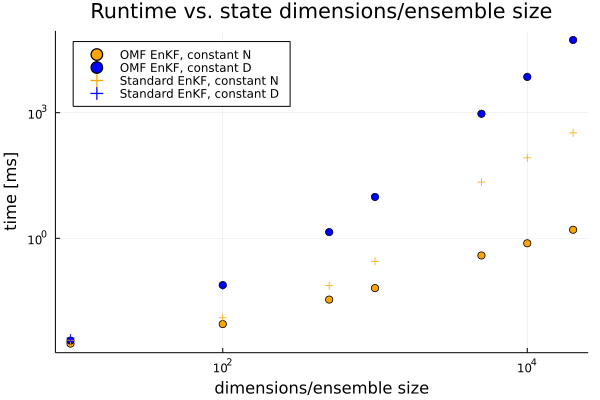

In [12]:
scatter(
    Ds, 
    map(in_ms, omf_benchmark_results_per_D), 
    title="Runtime vs. state dimensions/ensemble size", 
    xlabel="dimensions/ensemble size", 
    ylabel="time [ms]",
    xaxis=:log,
    yaxis=:log,
    label="OMF EnKF, constant N",
    legend=:topleft,
    markershape=:circle,
    markercolor="orange",
)
scatter!(
    Ns, 
    map(in_ms, omf_benchmark_results_per_N), 
    label="OMF EnKF, constant D",
    markershape=:circle,
    markercolor="blue",
)
scatter!(
    Ns, 
    map(in_ms, standard_benchmark_results_per_D), 
    label="Standard EnKF, constant N",
    markershape=:cross,
    markercolor="orange",
)
scatter!(
    Ns, 
    map(in_ms, standard_benchmark_results_per_N), 
    label="Standard EnKF, constant D",
    markershape=:cross,
    markercolor="blue",
)